In [1]:
!pip install keras-tuner

     |████████████████████████████████| 133 kB 13.5 MB/s 


In [2]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input, LSTM
from sklearn.model_selection import train_test_split
import pprint as pp
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


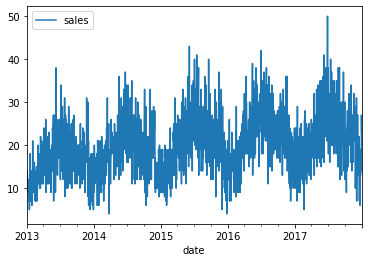

In [4]:
df = pd.read_excel("/content/drive/MyDrive/dataset.xlsx")
df.plot(x = 'date', y = 'sales')
plt.show()

In [5]:
raw_seq = df['sales']

In [6]:
train_seq = raw_seq[:1095]
val_seq = raw_seq[1095:1461].reset_index(drop=True)
test_seq = raw_seq[1461:].reset_index(drop=True)

In [7]:
print(train_seq.size, val_seq.size, test_seq.size)

1095 366 365


In [8]:
# univariate data preparation
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [9]:
n_steps = 30
n_features = 1
X_train, y_train = split_sequence(train_seq, n_steps)
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=10)
X_test, y_test = split_sequence(test_seq, n_steps)
X_val, y_val = split_sequence(val_seq, n_steps)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [10]:
def stacked_LSTM(hp):
    model = tf.keras.Sequential()
    model.add(Input(shape=(30, 1)))

    for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
      model.add(LSTM(units=hp.Int('units' + str(i), min_value=32, max_value=512, step=32), activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
      model.add(Dropout(hp.Float('dropout' + str(i), 0, 0.5, step=0.1, default=0)))
    model.add(Flatten())
    model.add(Dense(1))
    
    
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()])

    return model

In [11]:
tuner = kt.tuners.Hyperband(
    stacked_LSTM,
    objective='val_mean_squared_error',
    max_epochs=30,
    hyperband_iterations=5,
    directory='stacked_lstm_exp',
    project_name='demand forecasting')

In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout0 (Float)
{'default': 0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout1 (Float)
{'default': 0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [13]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [14]:
tuner.search(X_train_shuffled, y_train_shuffled, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 21 Complete [00h 02m 41s]
val_mean_squared_error: 48.78153610229492

Best val_mean_squared_error So Far: 34.25746536254883
Total elapsed time: 00h 47m 57s

Search: Running Trial #22

Value             |Best Value So Far |Hyperparameter
11                |2                 |num_layers
448               |256               |units0
0.2               |0.1               |dropout0
288               |320               |units1
0.3               |0.2               |dropout1
64                |32                |units2
0.2               |0.3               |dropout2
256               |480               |units3
0.5               |0.4               |dropout3
256               |96                |units4
0.2               |0.1               |dropout4
416               |96                |units5
0.2               |0.2               |dropout5
160               |192               |units6
0.1               |0.1               |dropout6
512               |224               |units7
0.2               |0

KeyboardInterrupt: ignored

In [15]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(30, 1))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 256)           264192    
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 320)           738560    
                                                                 
 dropout_1 (Dropout)         (None, 30, 320)           0         
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense (Dense)               (None, 1)                 9601      
                                                                 
Total params: 1,012,353
Trainable params: 1,012,353
Non-

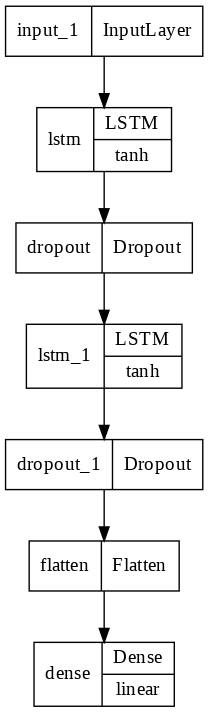

In [16]:
plot_model(best_model, show_layer_activations=True, dpi=100)

In [17]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [18]:
hist =  best_model.fit(X_train, y_train, batch_size=120, epochs=2000, verbose=2, validation_data=(X_val, y_val), callbacks=[callback])
score = best_model.evaluate(X_test, y_test, return_dict=True)
y_pred = best_model.predict(X_test)

Epoch 1/2000
9/9 - 10s - loss: 31.7890 - mean_absolute_error: 4.4011 - root_mean_squared_error: 5.6382 - mean_absolute_percentage_error: 26.6139 - mean_squared_error: 31.7890 - val_loss: 33.1528 - val_mean_absolute_error: 4.5941 - val_root_mean_squared_error: 5.7578 - val_mean_absolute_percentage_error: 24.1967 - val_mean_squared_error: 33.1528 - 10s/epoch - 1s/step
Epoch 2/2000
9/9 - 5s - loss: 31.3611 - mean_absolute_error: 4.3981 - root_mean_squared_error: 5.6001 - mean_absolute_percentage_error: 28.2480 - mean_squared_error: 31.3611 - val_loss: 34.3717 - val_mean_absolute_error: 4.5998 - val_root_mean_squared_error: 5.8627 - val_mean_absolute_percentage_error: 21.7098 - val_mean_squared_error: 34.3717 - 5s/epoch - 526ms/step
Epoch 3/2000
9/9 - 5s - loss: 28.9415 - mean_absolute_error: 4.2334 - root_mean_squared_error: 5.3797 - mean_absolute_percentage_error: 27.3588 - mean_squared_error: 28.9415 - val_loss: 34.2811 - val_mean_absolute_error: 4.6314 - val_root_mean_squared_error: 5.

In [19]:
best_model.evaluate(X_train, y_train, return_dict=True)

34/34 [==============================] - 2s 55ms/step - loss: 20.4749 - mean_absolute_error: 3.5396 - root_mean_squared_error: 4.5249 - mean_absolute_percentage_error: 22.2427 - mean_squared_error: 20.4749


{'loss': 20.474891662597656,
 'mean_absolute_error': 3.5395729541778564,
 'mean_absolute_percentage_error': 22.242687225341797,
 'mean_squared_error': 20.474891662597656,
 'root_mean_squared_error': 4.524919033050537}

In [20]:
best_model.evaluate(X_val, y_val, return_dict=True)

11/11 [==============================] - 1s 56ms/step - loss: 25.9396 - mean_absolute_error: 4.0876 - root_mean_squared_error: 5.0931 - mean_absolute_percentage_error: 20.5084 - mean_squared_error: 25.9396


{'loss': 25.939586639404297,
 'mean_absolute_error': 4.0875983238220215,
 'mean_absolute_percentage_error': 20.508424758911133,
 'mean_squared_error': 25.939586639404297,
 'root_mean_squared_error': 5.09309196472168}

In [21]:
score

{'loss': 27.144554138183594,
 'mean_absolute_error': 4.150126934051514,
 'mean_absolute_percentage_error': 20.795665740966797,
 'mean_squared_error': 27.144554138183594,
 'root_mean_squared_error': 5.210043430328369}

In [22]:
print(hist.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'mean_absolute_percentage_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'val_mean_absolute_percentage_error', 'val_mean_squared_error'])


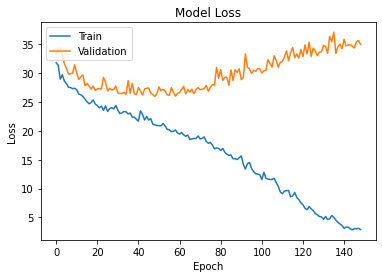

In [23]:
# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("stacked_lstm_loss.png", dpi=300)
plt.show()

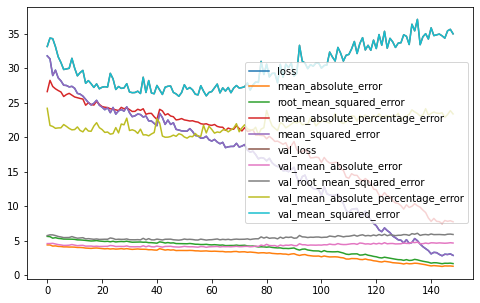

In [24]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.show()

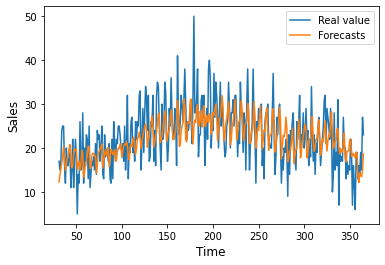

In [25]:
dates = np.array(range(31, 366))
plt.plot(dates, y_test, label='Real value')
plt.plot(dates, y_pred, label='Forecasts')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.savefig("stacked_lstm_forecast.png", dpi=500)
plt.show()

In [26]:
from scipy import stats
stats.ttest_ind(y_pred, y_test)

Ttest_indResult(statistic=array([-1.2370563], dtype=float32), pvalue=array([0.2165009]))

In [27]:
best_model.save('stacked_lstm.h5')